In [4]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
import copy
from datetime import datetime
import pandas as pd

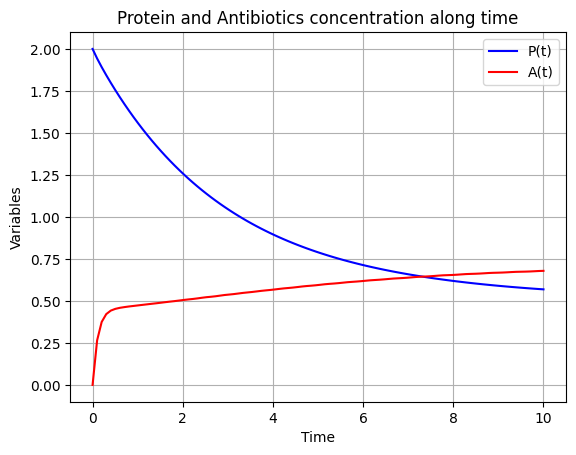

In [5]:
# Definir la función de modelo que representa el sistema de EDOs
def model(t, variables, n, k1, k2, phi_in, phi_out, A_out, v, km, klanda, landa0):
    P, A = variables
    alpha = landa0/(1+klanda*A) #A initial o A a lo largo del tiempo(FUERA O DENTRO)
    dPdt = alpha*n*(1+k2)/((1+k1*A)**2*(1+k2*P)) - alpha*P
    dAdt = phi_in*A_out - phi_out*A - v*P*A/(km+P) - alpha*A
    return [dPdt, dAdt]


t_span = [0, 10]

# Initial conditions and constants
n = 1;k1 = 1 ;k2 = 2; phi_in = 1; phi_out = 2; A_out =  4;v = 10; km = 1; klanda = 1; landa0 = 0.43

initial_conditions = [2, 0]  

sol = solve_ivp(model, t_span, initial_conditions, args=(n,k1,k2, phi_in, phi_out, A_out, v, km, klanda, landa0), t_eval=np.linspace(0, 10, 100))

plt.figure()
plt.plot(sol.t, sol.y[0], 'b-', label='P(t)')
plt.plot(sol.t, sol.y[1], 'r-', label='A(t)')
plt.xlabel('Time')
plt.ylabel('Variables')
plt.title('Protein and Antibiotics concentration along time')
plt.grid(True)
plt.legend()
#plt.show()

In [6]:
## Metropoli Hastings

# Experimental data from Paper ''C Reding et al. “The antibiotic dosage of fastest resistance evolution: gene ampli-
#fications underpinning the inverted-U''
df = pd.read_csv('C:/Users/raque/Documents/UNIVERSIDAD/UC3M/TFM/programación/montecarlo_data.csv')
P = df['P'];Aout = df['Aout'];n = df['n'];Perr = df['Perr']

In [7]:
#Constats array equivalence with model constants
#k1 = 1         k2 = 2          phi_in = 1      phi_out = 2     v = 10          km = 1          klanda = 1      alpha*beta
#constants[0]   constants[1]    constants[2]    constants[3]    constants[4]    constants[5]    constants[6]    constants[7]  

def model_function(vars,n,Aout, constants):
    P,A,landa = vars
    landa0 = 0.43
    eq1 = landa - landa0/(1+constants[6]*A)
    eq2 = A - constants[2]*Aout/(constants[3] + constants[4]*P/(constants[5]+P) + landa)
    eq3 = (1+constants[1]*P)*P - (n*constants[7])/(landa*(1+constants[0]*A)**2)

    return [eq1, eq2, eq3]


def solve_system(n,Aout,constants):
    initial_guess = [1, 1, 1]
    soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))
    return soluciones

def compute_P_predicted(n,Aout,constants):
    #Solve system with given constants and return Predicted Protein level
    P_predicted = []
    for i in range (0,len(n)):
        P_predicted.append(solve_system(n[i],Aout[i],constants)[0])
    return P_predicted 

'''def densidad_probabilidad(P,P_predicted):
    #MH1 y 2
    diferencia_cuadrada = np.sum((P_predicted - P)**2)
    return np.exp(-0.5 * diferencia_cuadrada)  '''

'''def densidad_probabilidad2(P,P_predicted,n,Aout,constants):
    P_predicted = compute_P_predicted(n,Aout,constants)
    diferencia_cuadrada = np.sum((P_predicted - P)**2)
    return np.exp(-0.5 * diferencia_cuadrada)  '''


'def densidad_probabilidad(P,P_predicted):\n    #MH1 y 2\n    diferencia_cuadrada = np.sum((P_predicted - P)**2)\n    return np.exp(-0.5 * diferencia_cuadrada)  \n\ndef densidad_probabilidad2(P,P_predicted,n,Aout,constants):\n    P_predicted = compute_P_predicted(n,Aout,constants)\n    diferencia_cuadrada = np.sum((P_predicted - P)**2)\n    return np.exp(-0.5 * diferencia_cuadrada)  '

In [8]:
def likelihood(P, n, Aout, constants, sigma):
    P_predicted = compute_P_predicted(n,Aout,constants)
    residual = P - P_predicted
    likelihood = np.prod(1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-0.5 * (residual / sigma) ** 2)) #Distribución normal
    return likelihood

'''def likelihood2(P, n, Aout, constants, sigma):
    P_predicted = compute_P_predicted(n, Aout, constants)
    residual = P - P_predicted
    likelihood = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (residual / sigma) ** 2)
    return likelihood'''

def likelihood2(P,P_predicted, sigma):
    #likelihood without calculating the P_predicted when we remove by high Perr
    residual = P - P_predicted
    likelihood = np.prod(1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-0.5 * (residual / sigma) ** 2)) #Distribución normal
    return likelihood

# Función para calcular el paso para los parámetros
def propose_step(params, step_size):
    return params + step_size * np.random.randn(len(params))

# Implementación del algoritmo Metropolis-Hastings
def metropolis_hastings3(P, n, Aout, initial_params, step_size, num_iterations, sigma):
    #Montecarlo metropoli hastings method using normal likelihood
    #WITHOUT considering the error in the measurement of P
    accepted_samples = []
    current_params = initial_params

    for _ in range(num_iterations):
        #print('3')
        proposed_params = propose_step(current_params, step_size)
        likelihood_current = likelihood(P, n, Aout, current_params, sigma)
        print(likelihood_current)
        likelihood_proposed = likelihood(P, n, Aout, proposed_params, sigma)
        print(likelihood_proposed)
        acceptance_ratio = likelihood_proposed / likelihood_current
        print(acceptance_ratio)
        if acceptance_ratio >= np.random.rand():
            accepted_samples.append(proposed_params)
            current_params = proposed_params
        else:
            accepted_samples.append(current_params)
    print(current_params)
    return np.array(accepted_samples)


In [9]:
def metropolis_hastings4(P, n, Aout, initial_params, step_size, num_iterations, sigma):
    #Montecarlo metropoli hastings method using normal likelihood
    #Considering the error in the measurement of P
    accepted_samples = []
    current_params = initial_params
    min_error = 5
    const_min = initial_params
    for _ in range(num_iterations):
        
        if _%1000 == 0:
            print(_)

        proposed_params = propose_step(current_params, step_size)
        P_predicted = compute_P_predicted(n,Aout,proposed_params)
        P_copy = copy.deepcopy(P)
        error_P = abs(P_copy-P_predicted)
        if min_error > sum(error_P)/len(error_P):
            const_min = proposed_params
        #print(error_P)
        for i in range (len(error_P)-1,0,-1):
            if Perr[i]>error_P[i]:
                P_predicted.pop(i); P_copy.pop(i)

        likelihood_current = likelihood2(P_copy,P_predicted, sigma)
        #print(likelihood_current)
        likelihood_proposed = likelihood(P, n, Aout, proposed_params, sigma)
        #print(likelihood_proposed)
        acceptance_ratio = likelihood_proposed / likelihood_current


        if acceptance_ratio >= np.random.rand():
            accepted_samples.append(proposed_params)
            current_params = proposed_params
        else:
            accepted_samples.append(current_params)

    return np.array(accepted_samples),const_min

In [10]:
num_iterations = 10000000 

sigma_propuesta = 0.03  
step_size = 0.001

# Metropolis-Hastings algorithm execution 

#Avoid initial likelihood equal zero
for _ in range(num_iterations):
    initial_params = np.random.rand(8) 
    print(likelihood(P, n, Aout, initial_params, sigma_propuesta))
    if likelihood(P, n, Aout, initial_params, sigma_propuesta) != 0:
        print(initial_params) 
        break
        

print('Empieza')

muestras_constantes,const_min = metropolis_hastings4(P, n, Aout, initial_params, step_size, num_iterations, sigma_propuesta)
print(const_min)

fecha_hora_actual = datetime.now()
titulo = 'C:\\Users\\raque\\Documents\\UNIVERSIDAD\\UC3M\\TFM\\programación\\montecarlo_constants\\'+fecha_hora_actual.strftime("%Y-%m-%d_%H-%M-%S_") + "_muestras_constantes"+str(num_iterations)+"_"+str(sigma_propuesta)+"_"+str(step_size)+".txt"
np.savetxt(titulo, muestras_constantes)



0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\raque\AppData\Local\Temp\ipykernel_8456\1260316686.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))
C:\Users\raque\AppData\Local\Temp\ipykernel_8456\1260316686.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\raque\AppData\Local\Temp\ipykernel_8456\1260316686.py:16: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\raque\AppData\Local\Temp\ipykernel_8456\2682009865.py:28: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = likelihood_proposed / likelihood_current
C:\Users\raque\AppData\Local\Temp\ipykernel_8456\2682009865.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio = likelihood_proposed / likelihood_current


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [11]:
initial_params = [0.79019879, 0.24830442, 0.10640616, 0.51890808, 0.70229585, 0.75636407, 0.3400697,  0.7298991]
likelihood(P, n, Aout, initial_params, sigma_propuesta)

0.0

In [39]:
# Estimate the values ​​of the constants by taking the average of the samples
valores_constantes_estimados = np.mean(muestras_constantes[round(0.35*num_iterations):], axis=0)   #Last 85% estimations

# Estimate the values ​​of the constants I take the last estimate
valores_constantes_estimados2 = muestras_constantes[-1]

print("Valores estimados de las constantes MEAN:")
print(valores_constantes_estimados)

P_predicted1 = compute_P_predicted(n,Aout,valores_constantes_estimados)
error1 = abs(P-P_predicted1)
#print(error1)

Valores estimados de las constantes MEAN:
[ 0.36765689  1.26001635  0.24335831  1.4766571   0.05247676 -0.50245532
  0.70413014  1.0230105 ]


In [40]:
print('Mean error,', np.mean(error1))
print('P ESTIMADO            P REAL')
for v1, v2 in zip(P_predicted1, P):
    print(v1,'     ', v2)

Mean error, 0.4170236584385201
P ESTIMADO            P REAL
1.1904844839533089       1.0
1.1521550206202347       1.0
1.1370474540763544       1.0
1.1262393923741298       1.355
1.161434699512428       1.569
1.3746112671595316       1.753
1.0473401750650113       1.148
1.4710956464226081       1.71
1.8482693623796058       1.737
0.9823719911948355       0.978
1.7587347187212876       1.725
1.86612173030523       1.799
0.9139676961507873       0.838
1.6695584530625043       1.629
1.8694706262472245       1.806
0.47864191073195606       0.758
-2.424674072491266       1.28
1.8674723748743438       2.067
-1.527252061641187       0.754
0.4813482906163883       0.488
0.48242708687850455       0.538


In [41]:
print('------------------------------')
valores_constantes_estimados = valores_constantes_estimados2
print("Valores estimados de las constantes END:")
print(valores_constantes_estimados)

P_predicted2 = compute_P_predicted(n,Aout,valores_constantes_estimados)
error2 = abs(P-P_predicted2)
#print(error2)


------------------------------
Valores estimados de las constantes END:
[ 0.06184778  0.61015941  0.45107794  0.57095304  0.23274119 -0.49722963
  0.1239215   0.52088895]


C:\Users\raque\AppData\Local\Temp\ipykernel_8456\1260316686.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))


In [42]:
print('Mean error,', np.mean(error2))
print('P ESTIMADO            P REAL')
for v1, v2 in zip(P_predicted2, P):
    print(v1,'     ', v2)

Mean error, 0.1763147641982086
P ESTIMADO            P REAL
0.9568198780265449       1.0
0.9208763244555648       1.0
0.9067494069169131       1.0
0.9719351206990472       1.355
1.0068002950261754       1.569
1.2204568390340087       1.753
0.9382214435487481       1.148
1.3753932394262125       1.71
1.774719369786008       1.737
0.9112506615849503       0.978
1.7385664522857966       1.725
1.8559483554723641       1.799
0.8735402261642687       0.838
1.6904881893844437       1.629
1.9132680270038498       1.806
0.8459005685477916       0.758
1.6998636689750395       1.28
1.9567301680600964       2.067
0.7760016769246201       0.754
0.7004500012071694       0.488
0.7710968891892903       0.538


In [43]:
print(const_min)
P_predicted3 = compute_P_predicted(n,Aout,const_min)
error3 = abs(P-P_predicted3)
#print(error3)
print('Mean error,', np.mean(error3))

[ 0.06184778  0.61015941  0.45107794  0.57095304  0.23274119 -0.49722963
  0.1239215   0.52088895]
Mean error, 0.1763147641982086


C:\Users\raque\AppData\Local\Temp\ipykernel_8456\1260316686.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  soluciones = fsolve(model_function, initial_guess,args=(n,Aout,constants))


In [44]:
print('P ESTIMADO            P REAL')
for v1, v2 in zip(P_predicted3, P):
    print(v1,'     ', v2)

P ESTIMADO            P REAL
0.9568198780265449       1.0
0.9208763244555648       1.0
0.9067494069169131       1.0
0.9719351206990472       1.355
1.0068002950261754       1.569
1.2204568390340087       1.753
0.9382214435487481       1.148
1.3753932394262125       1.71
1.774719369786008       1.737
0.9112506615849503       0.978
1.7385664522857966       1.725
1.8559483554723641       1.799
0.8735402261642687       0.838
1.6904881893844437       1.629
1.9132680270038498       1.806
0.8459005685477916       0.758
1.6998636689750395       1.28
1.9567301680600964       2.067
0.7760016769246201       0.754
0.7004500012071694       0.488
0.7710968891892903       0.538


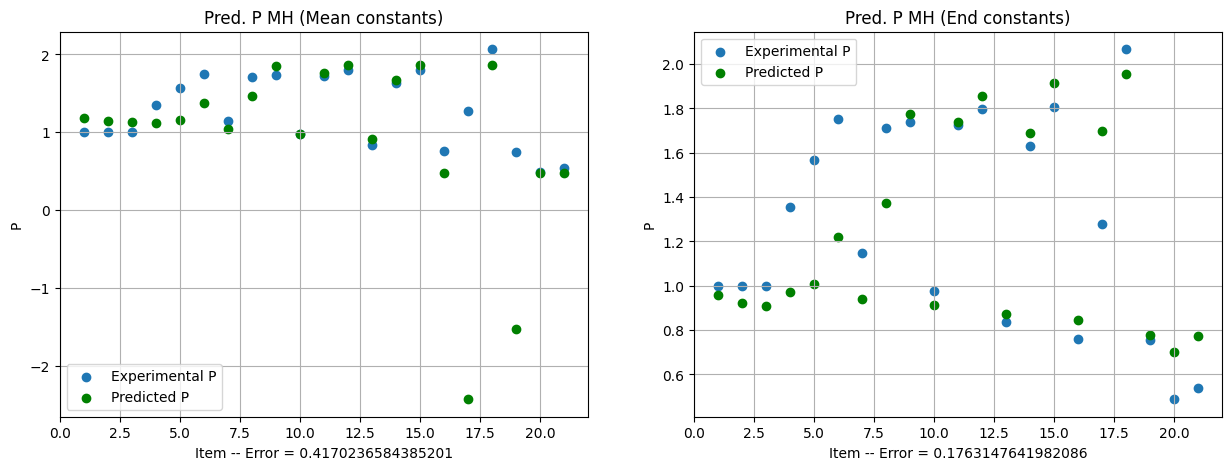

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(1, len(P)+1)), P, label='Experimental P')
plt.scatter(list(range(1, len(P)+1)), P_predicted1, color='green', label='Predicted P')
plt.grid()
plt.xlabel(f'Item -- Error = {np.mean(error1)}')
plt.ylabel('P')
plt.legend()
plt.title('Pred. P MH (Mean constants)')

plt.subplot(1, 2, 2)
plt.scatter(list(range(1, len(P)+1)), P, label='Experimental P')
plt.scatter(list(range(1, len(P)+1)), P_predicted2, color='green', label='Predicted P')
plt.grid()
plt.xlabel(f'Item -- Error = {np.mean(error2)}')
plt.ylabel('P')
plt.legend()
plt.title('Pred. P MH (End constants)')

plt.show()

Text(0.5, 1.0, 'Pred. P MH (Mean constants)')

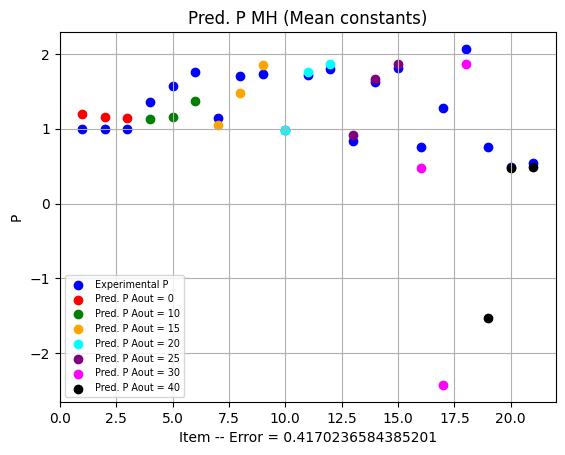

In [46]:
# Approximate Protein by different value of Antibiotic 

plt.figure()
plt.scatter(list(range(1, len(P)+1)), P, color='blue', label='Experimental P')
plt.scatter(list(range(1, 4)), P_predicted1[0:3], color='red', label='Pred. P Aout = 0')
plt.scatter(list(range(4, 7)), P_predicted1[3:6], color='green', label='Pred. P Aout = 10')
plt.scatter(list(range(7, 10)), P_predicted1[6:9], color='orange', label='Pred. P Aout = 15')
plt.scatter(list(range(10, 13)), P_predicted1[9:12], color='cyan', label='Pred. P Aout = 20')
plt.scatter(list(range(13, 16)), P_predicted1[12:15], color='purple', label='Pred. P Aout = 25')
plt.scatter(list(range(16, 19)), P_predicted1[15:18], color='magenta', label='Pred. P Aout = 30')
plt.scatter(list(range(19, 22)), P_predicted1[18:21], color='black', label='Pred. P Aout = 40')


plt.grid()
plt.xlabel(f'Item -- Error = {np.mean(error1)}')
plt.ylabel('P')
plt.legend(fontsize='x-small')
plt.title('Pred. P MH (Mean constants)')